<a href="https://colab.research.google.com/github/Patrick-Munyao/Signature_Verification_Siamese_Network/blob/main/Signature_Verification_Siamese_CNN_Pair_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Defining the Question 

###a) Specifying the Data Analytic Question




The main objective in this study is to build a model that, once trained on relevant data, can verify if a signature is genuine or forged.

###b) Defining the Metrics for success

To satisfy the objective of this study, we will build a model using Siaseme Convolutional Neural Network (sometimes called a twin neural network). Siamese network is a type of deep learning network that uses two or more identical subnetworks that have the same architecture and share the same parameters and weights. Siaseme networks are typically used in tasks that involve finding the relationship between two comparable things; and their shared weights mean that there are fewer parameters to learn during training and they can produce good results with a relatively small amount of training data. As such, we consider Siaseme CNN appropraite for this study.

A threshhold on the Euclidean distance between the signatures wil be used to determine if a signature is forged or genuine, and we aim at achieving a model accuracy of at least 80%.

###c) Understanding the context

With the mass digitization of activities in the world today, it makes it necessary to also revolutionalize the verification of signatures,
 which has mainly relied on human- manual effort in the past. 

By definition, a signature is an identification mark that a person appends on documents or texts. It remains one of the most popular and commonly accepted biometric hallmarks that has been used since the ancient times for verifying different entities related to human beings; documents, forms, bank cheques etc. Therefore, signature verification is a critical task and many efforts have been made to remove the uncertainty involved in the manual authentication procedure, which makes signature verification an important research line in the field of machine learning and pattern recognition.

Since signature is the primary mechanism both for authentication
and authorization in legal transactions, the need for efficient
automated solutions for signature verification has increased.
Unlike a password, PIN, or key cards – identification
data that can be forgotten, lost, stolen or shared – the captured
values of the handwritten signature are unique to an individual
and virtually impossible to duplicate. Signature verification is
natural and intuitive. The primary advantages that automated signature verification has is efficiency and aleviation of the human error. With signatures being widely accepted as the common method of identity verification, we regard this study relevant in serving solutions to current problems of identifcation.

### d) Recording the Experimental Design



Steps implemented are as follows:

1.) Business Understanding

2.) Reading and previewing the data

3.) Data preprocessing 

4.) Modelling

6.) Challenging the solution

7.) Conclusion/recommendations

### e) Relevance of the data
The dataset utilized in this study consist of train and test directories, each with image folders of forged and genuine signatures. The data was sourced from Kaggle.


#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import itertools # importing "itertools" for iterator operations 
import random
from keras import backend as K  #tensor manipulation library
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.regularizers import l2 #Regularizer that allows you to apply penalties on layer parameters or layer activity during optimization.
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model #Model groups layers into an object with training and inference features
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D,GlobalAveragePooling2D,
                                     Activation, Flatten, Dropout, Dense, Lambda)

## Uploading Data

In [2]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/hashbanger/signatures-recognition-full?select=signatures_full")

! unzip <signatures_full>

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: patrickmunyao
Your Kaggle Key: ··········


100%|██████████| 241M/241M [00:02<00:00, 95.4MB/s]



/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: ` unzip <signatures_full>'


### Preview Sample Images

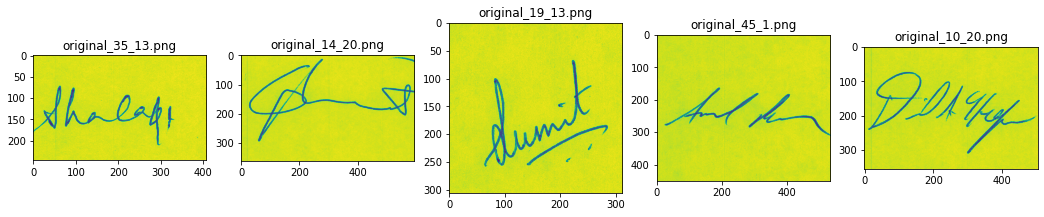

In [3]:
# Preview sample images - genuine

import matplotlib.image as mpimg
plt.figure(figsize=(18,18))

# Defining the image directory
image_dir='signatures-recognition-full/signatures_full/train/genuine'

# Extracting 5 random images
for x in range(5):
    file = random.choice(os.listdir(image_dir))
    image_path= os.path.join(image_dir, file)
    image=mpimg.imread(image_path)
    ax=plt.subplot(1,5,x+1)
    ax.title.set_text(file)
    plt.imshow(image)

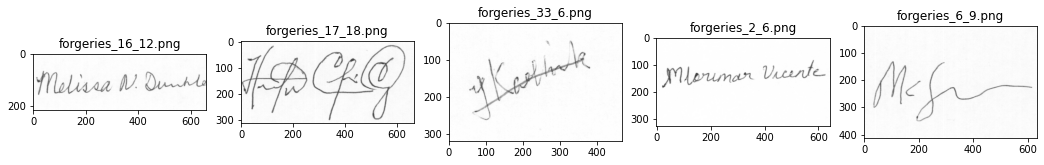

In [4]:
# Preview sample images - forged
# Image size
plt.figure(figsize=(18,18))

# Defining the image directory
image_dir='signatures-recognition-full/signatures_full/train/forged'

# Extracting 5 random images
for x in range(5):
    file = random.choice(os.listdir(image_dir))
    image_path= os.path.join(image_dir, file)
    image=mpimg.imread(image_path)
    ax=plt.subplot(1,5,x+1)
    ax.title.set_text(file)
    plt.imshow(image)    

# Data Preprocessing

##Group the train images in the forged category

In [6]:
path='./signatures-recognition-full/signatures_full/train/forged'
list_name =[]
for root, dirs, files in os.walk(path):
    list_name.extend(files)
from collections import defaultdict
#Does not raise KeyError. It provides a default value for the key that does not exists

dic=defaultdict(list)


for i in list_name:
    filename,ext =os.path.splitext(i)
    cat, group, img_index = filename.split('_')
    dic[group].append(img_index)

In [7]:
#create a sub_directory called forged_person inside the forged directory
directory='forged_person'
parent_dir='./signatures-recognition-full/signatures_full/train/forged'
path = os.path.join(parent_dir, directory)
os.makedirs(path)

In [8]:
#group every signature from each individual in one folder
import shutil
new_folder='./signatures-recognition-full/signatures_full/train/forged/forged_person'
path='./signatures-recognition-full/signatures_full/train/forged'

for i in dic:        
        if not os.path.exists(os.path.join(new_folder,i)):
            os.mkdir(os.path.join(new_folder,i))
            for img in dic[i]:
                old_image = os.path.join(path,'forgeries_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)

                shutil.move(old_image,os.path.join(new_path,new_image)) #Recursively moves a file or directory to another location and returns the destination.
                #If the destination directory already exists then src is moved inside that directory.
                
        else:
            for img in dic[i]:
                old_image = os.path.join(path,'forgeries_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)
                print(new_path)
                shutil.move(old_image,os.path.join(new_path,new_image))

## Group the train images in the genuine category

In [9]:
path='./signatures-recognition-full/signatures_full/train/genuine'
list_name_2 =[]
for root, dirs, files in os.walk(path):
    list_name_2.extend(files)
from collections import defaultdict

dic_2=defaultdict(list)


for i in list_name_2:
    filename,ext =os.path.splitext(i)
    cat, group, img_index = filename.split('_')
    dic_2[group].append(img_index)

In [10]:
#create a sub_directory called genuine_person inside the genuine directory

directory='genuine_person'
parent_dir='./signatures-recognition-full/signatures_full/train/genuine'
path = os.path.join(parent_dir, directory)
os.makedirs(path)

In [11]:
#group every signature from each individual in one folder

new_folder='./signatures-recognition-full/signatures_full/train/genuine/genuine_person'
path='./signatures-recognition-full/signatures_full/train/genuine'

for i in dic_2:        
        if not os.path.exists(os.path.join(new_folder,i)):
            os.mkdir(os.path.join(new_folder,i))
            for img in dic_2[i]:
                old_image = os.path.join(path,'original_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)

                shutil.move(old_image,os.path.join(new_path,new_image))
        else:
            for img in dic_2[i]:
                old_image = os.path.join(path,'original_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)
                print(new_path)
                shutil.move(old_image,os.path.join(new_path,new_image))

## Group the test images in the fogery category

In [12]:
path='./signatures-recognition-full/signatures_full/test/forged'
list_name =[]
for root, dirs, files in os.walk(path):
    list_name.extend(files)
from collections import defaultdict

dic=defaultdict(list)


for i in list_name:
    filename,ext =os.path.splitext(i)
    cat, group, img_index = filename.split('_')
    dic[group].append(img_index)

In [13]:
directory='forged_person'
parent_dir='./signatures-recognition-full/signatures_full/test/forged'
path = os.path.join(parent_dir, directory)
os.makedirs(path)

In [14]:
new_folder='./signatures-recognition-full/signatures_full/test/forged/forged_person'
path='./signatures-recognition-full/signatures_full/test/forged'

for i in dic:        
        if not os.path.exists(os.path.join(new_folder,i)):
            os.mkdir(os.path.join(new_folder,i))
            for img in dic[i]:
                old_image = os.path.join(path,'forgeries_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)

                shutil.move(old_image,os.path.join(new_path,new_image))
        else:
            for img in dic[i]:
                old_image = os.path.join(path,'forgeries_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)
                print(new_path)
                shutil.move(old_image,os.path.join(new_path,new_image))

## Group the test images in the genuine category

In [15]:
path='./signatures-recognition-full/signatures_full/test/genuine'
list_name =[]
for root, dirs, files in os.walk(path):
    list_name.extend(files)
from collections import defaultdict

dic=defaultdict(list)


for i in list_name:
    filename,ext =os.path.splitext(i)
    cat, group, img_index = filename.split('_')
    dic[group].append(img_index)

In [16]:
directory='genuine_person'
parent_dir='./signatures-recognition-full/signatures_full/test/genuine'
path = os.path.join(parent_dir, directory)
os.makedirs(path)

In [17]:
new_folder='./signatures-recognition-full/signatures_full/test/genuine/genuine_person'
path='./signatures-recognition-full/signatures_full/test/genuine'

for i in dic:        
        if not os.path.exists(os.path.join(new_folder,i)):
            os.mkdir(os.path.join(new_folder,i))
            for img in dic[i]:
                old_image = os.path.join(path,'original_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)

                shutil.move(old_image,os.path.join(new_path,new_image))
        else:
            for img in dic[i]:
                old_image = os.path.join(path,'original_{}_{}.png'.format(i,img))
                new_image = r'{}.png'.format(img)
                new_path =os.path.join(new_folder,i)
                print(new_path)
                shutil.move(old_image,os.path.join(new_path,new_image))

### Create train groups

In [18]:
#function to create a list of lists, with each list containing signature images of a single person

# 1. Genuine groups

path='./signatures-recognition-full/signatures_full/train/genuine/genuine_person'
#create a list of directories containing signatures of individuals
dir_list_gen = next(os.walk(path))[1] #root, folder, files
#sort the list
dir_list_gen.sort()
#create an empty list
orig_groups=[]
for directory in dir_list_gen:
    images = os.listdir(path+'/'+directory)
    images.sort()
    images = [path+'/'+directory+'/'+x for x in images] #list comprehension generating the file path of each img inside the dir
    orig_groups.append(images) #appending the list inside the orig groups

In [19]:
orig_groups[2]

['./signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/1.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/10.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/11.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/12.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/13.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/14.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/15.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/16.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/17.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/18.png',
 './signatures-recognition-full/signatures_full/train/genuine/genuine_person/11/19.png',
 './signatures-recogni

In [20]:
assert dir_list_gen==sorted(os.listdir(path)) #assert function tests if a condition is true

In [21]:
# 2. Forged groups

path_2='./signatures-recognition-full/signatures_full/train/forged/forged_person'

dir_list_forg = sorted(os.listdir(path_2))
dir_list_forg.sort()

forg_groups = []
for directory in dir_list_forg:
    images = os.listdir(path_2+'/'+directory)
    images.sort()
    images = [path_2+'/'+directory+'/'+x for x in images]
    forg_groups.append(images) 

In [22]:
len(orig_groups),len(forg_groups)

(55, 55)

In [23]:
#check the number of signatures per individual. Both genuine and forged
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]
print(orig_lengths)
print(forg_lengths)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [24]:
#split data into training and validation
#40 individuals for training and 15 for validation
orig_train, orig_val = orig_groups[:40], orig_groups[40:]
forg_train, forg_val = forg_groups[:40], forg_groups[40:]

In [25]:
# All the images will be converted to the same size before processing
img_h, img_w = 155,220

### Visualize samples from training data

In [26]:
def visualize_sample_signature():
    #Function to randomly select a signature from train set and
    #print two genuine copies and one forged copy
    #create the axes of the plots. 1 row and 3 columns for three images to be outputed

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 10))

    #randomly select and index in the range of the training set size

    k = np.random.randint(len(orig_train))

    #randomly get two original signatures for person k

    orig_img_names = random.sample(orig_train[k], 2)

    #randomly get one forged signature in for person k

    forg_img_name = random.sample(forg_train[k], 2)

    #read images using open cv module
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img1 = plt.imread(forg_img_name[0], 0)
    forg_img2 = plt.imread(forg_img_name[1], 0)


    #resize the images
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img1 = cv2.resize(forg_img1, (img_w, img_h))
    forg_img2 = cv2.resize(forg_img2, (img_w, img_h))


    #plot the images
    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img1, cmap = 'gray')
    ax4.imshow(forg_img2, cmap = 'gray')


    # Set titles
    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')
    ax4.set_title('Forged Copy')
    ax4.axis('off')

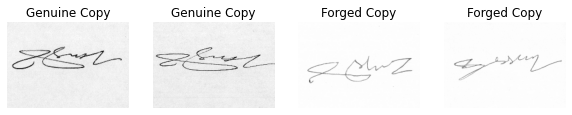

In [27]:
visualize_sample_signature()

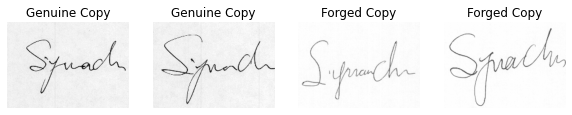

In [28]:
visualize_sample_signature()

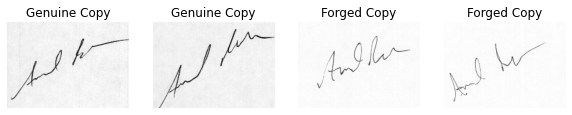

In [29]:
visualize_sample_signature()

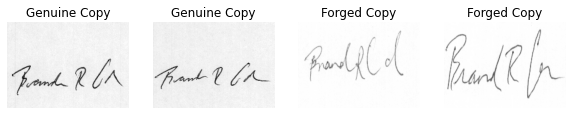

In [30]:
visualize_sample_signature()

### Create test groups

In [31]:
# 1. Genuine groups

path_3='./signatures-recognition-full/signatures_full/test/genuine/genuine_person'
dir_list_gen_test = next(os.walk(path))[1]
dir_list_gen_test.sort()

orig_groups_test=[]
for directory in dir_list_gen_test:
    images = os.listdir(path_3+'/'+directory)
    images.sort()
    images = [path_3+'/'+directory+'/'+x for x in images]
    orig_groups_test.append(images)

In [32]:
# 2. Forged groups

path_4='./signatures-recognition-full/signatures_full/test/forged/forged_person'
dir_list_forg_test = next(os.walk(path))[1]
dir_list_forg_test.sort()

forg_groups_test=[]
for directory in dir_list_forg_test:
    images = os.listdir(path_4+'/'+directory)
    images.sort()
    images = [path_4+'/'+directory+'/'+x for x in images]
    forg_groups_test.append(images)

## Create a batch generator that generates pairs of images

In [33]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    #Function to generate a batch of data with batch_size number of data points
    #Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 20 genuine signatures, hence we have 
        # 20 choose 2 = 190 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged ignatures of the same person.
        # Thus we make 20 * 12 = 240 Genuine-Forged image pairs for one person.
        # In all we have 40 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 40 * 190= 7600
        # Total number of Genuine-Forged pairs = 40 * 240 = 9600
        # Total no. of data points = 7600 + 9600 = 17200
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

## Create a Function to measure similarity

In [34]:
def euclidean_distance(vects):
    #Compute Euclidean Distance between two vectors
    
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [35]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

## Create the loss function for the model

In [36]:
def contrastive_loss(y_true, y_pred):          #contrastive_loss - This loss encourages the embedding to be close to each other for
                                               #the samples of the same label and the embedding to be far apart at least
                                               #by the margin constant for the samples of different labels

    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [37]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

###Define the Base Model

In [38]:
def build_siamese_model(inputShape, embeddingDim=48):

	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
 
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(32, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(32, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

 	# Third set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 
    # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)  # GlobalAveragePooling is a methodology used for better representation of a vector. Can be 1D/2D/3D
	outputs = Dense(embeddingDim)(pooledOutput)
 
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model



In [39]:
input_shape=(img_h, img_w, 1)
batch_sz = 128
num_train_samples = 40 * 190 + 40 * 240
num_val_samples = 190*15 + 240*15
num_train_samples, num_val_samples

(17200, 6450)

# Network Definition

In [40]:
base_network= build_siamese_model(input_shape)

input_1 = Input(shape=(input_shape))
input_2 = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_1)
processed_b = base_network(input_2)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_1, input_2], outputs=distance)

In [41]:
#Check the processor

tf.test.gpu_device_name()

'/device:GPU:0'

## Compiling the model

In [42]:
# compile model using Adam Optimizer and Contrastive loss function defined above

model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-6))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 48)           15664       ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

## Training the model

In [43]:
history = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 50,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              )

Epoch 1/50
134/134 [==============================] - 144s 961ms/step - loss: 0.4454 - val_loss: 0.5293
Epoch 2/50
134/134 [==============================] - 128s 960ms/step - loss: 0.4437 - val_loss: 0.5304
Epoch 3/50
134/134 [==============================] - 128s 962ms/step - loss: 0.4409 - val_loss: 0.5294
Epoch 4/50
134/134 [==============================] - 128s 963ms/step - loss: 0.4388 - val_loss: 0.5303
Epoch 5/50
134/134 [==============================] - 128s 961ms/step - loss: 0.4364 - val_loss: 0.5260
Epoch 6/50
134/134 [==============================] - 128s 961ms/step - loss: 0.4350 - val_loss: 0.5248
Epoch 7/50
134/134 [==============================] - 128s 961ms/step - loss: 0.4321 - val_loss: 0.5261
Epoch 8/50
134/134 [==============================] - 128s 959ms/step - loss: 0.4296 - val_loss: 0.5244
Epoch 9/50
134/134 [==============================] - 128s 958ms/step - loss: 0.4278 - val_loss: 0.5231
Epoch 10/50
134/134 [==============================] - 128s 960m

In [44]:
#history = tf.keras.callbacks.History()

In [45]:
# Save the entire model as a SavedModel.
#!mkdir -p sig_ver_model
#model.save('sig_ver_model/sign_model')

In [46]:
#save model

model.save("sig_ver_model")

INFO:tensorflow:Assets written to: sig_ver_model/assets


In [47]:
 #%tensorboard --logdir logs/fit

## Model Evaluation

In [48]:
def compute_accuracy_roc(predictions, labels):
    #Compute ROC accuracy with a range of thresholds on distances.
    
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
     #print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

## Create a batch generator for test set

In [49]:
def generate_batch_test(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 4 genuine signatures, hence we have 
        # 4 choose 2 = 6 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 3 randomly sampled Forged signatures of the same person.
        # Thus we make 4 * 3 = 12 Genuine-Forged image pairs for one person.
        # In all we have 55 person's data in the test data.
        # Total no. of Genuine-Genuine pairs = 55 * 6= 330
        # Total number of Genuine-Forged pairs = 55 * 12 = 660
        # Total no. of data points = 330 + 660 = 990
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 3))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [50]:
#size of test samples

num_test_samples = (55 * 6)+(55 * 12)

In [51]:
#use a batch size of 1 when generating the test set
#to get all the test data plus the respective labels, loop number of test samples times
test_gen = generate_batch_test(orig_groups_test, forg_groups_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [52]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.9924242424242424, 0.0513604253763333)



> **Accuracy** = **99.24%** and **Threshold** = **0.051**


Therefore, if the difference score is less than 0.051, a test image is predicted as Genuine and if the difference score is greater than 0.051, the test mage is predicted as Forged. 



In [53]:
def predict_score():
  
    #Predict distance score and classify test images as Genuine or Forged

    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

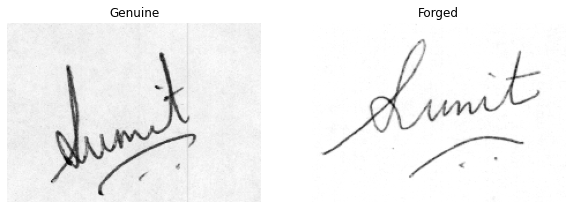

Difference Score =  0.08048036
Its a Forged Signature


In [54]:
predict_score()

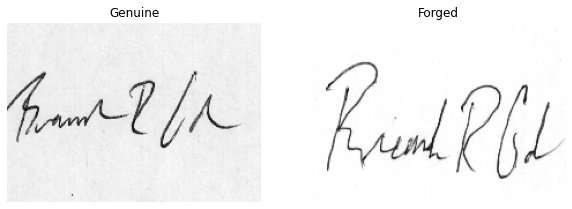

Difference Score =  0.14170995
Its a Forged Signature


In [55]:
predict_score()

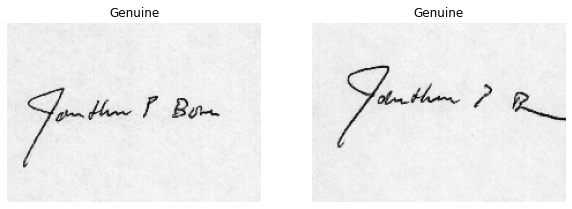

Difference Score =  0.04100837
Its a Genuine Signature


In [56]:
predict_score()

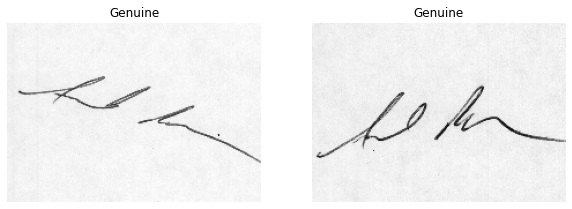

Difference Score =  0.04715389
Its a Genuine Signature


In [57]:
predict_score()

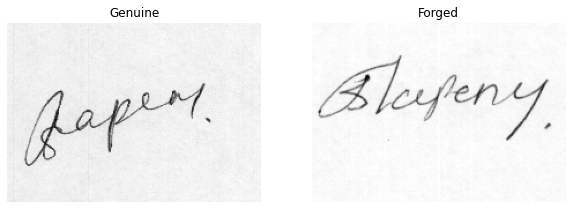

Difference Score =  0.08869416
Its a Forged Signature


In [58]:
predict_score()

# Challenging the solution

Based on the success metrics of our study, a Siamese Convolution Neural Network has been successfully created and attained an accuracy score of 99% against our target score of at least 80%. Therefore, this study is considered a success. 
 

#Recommendation

We recommend that transfer learning or any other relevant modelling be done for further insights and comparison of models' performance.